# Deep learning-based automated rock classification via high-resolution drone-captured core sample imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2024
***

## Build and Train NN-classifier
| Class             | OLD   | New   |
| ---               | ---   | ---   |
| Background        | 0     | 0     |
| Sandstone type 1  | 1     | 2     |
| Shaly Rock        | 2     | 3     |
| Sandstone type 2  | 3     | 4     |
| Carbonate         | 4     | 5     |
| Shale             | 5     | 6     |
| Sandstone type 3  | 6     | 7     |
| Box               | 10    | 1     |

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.v2 as Transforms

In [3]:
def check_torch():
    '''
    Check if Torch is successfully built with GPU support
    '''
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    print('\n'+'-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60+'\n')
    return None

check_torch()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.1.2.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [4]:
class RockClassification(nn.Module):
    def __init__(self):
        super(RockClassification, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.convt4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.convt3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.convt1 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)

        self.bn0 = nn.BatchNorm2d(1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.upsm = nn.Upsample(scale_factor=2, mode='nearest')

        self.relu = nn.ReLU()
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        x = self.relu(self.bn3(self.convt4(self.upsm(x))))
        x = self.relu(self.bn2(self.convt3(self.upsm(x))))
        x = self.relu(self.bn1(self.convt2(self.upsm(x))))
        x = self.relu(self.bn0(self.convt1(self.upsm(x))))

        return torch.round(x) #self.soft(x)

In [442]:
class CustomDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.input_filenames = os.listdir(input_dir)
        self.input_filenames.sort()

        self.output_dir = output_dir
        self.output_filenames = os.listdir(output_dir)
        self.output_filenames.sort()
        self.remap_dict = {0:0, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 10:1}

        self.transform = transform

    def __len__(self):
        return len(self.input_filenames)

    def __getitem__(self, idx):
        input_npy_path  = os.path.join(self.input_dir, self.input_filenames[idx])
        output_npy_path = os.path.join(self.output_dir, self.output_filenames[idx])

        x = np.load(input_npy_path)/255
        input_img = torch.tensor(x).unsqueeze(0).nan_to_num(0).type(torch.float32)

        #output_img = np.vectorize(self.remap_dict.get)(np.load(output_npy_path))
        output_img = np.load(output_npy_path)
        output_img = torch.tensor(output_img).unsqueeze(0).nan_to_num(0).type(torch.int32)

        if self.transform is not None:
            input_img, output_img = self.transform(input_img), self.transform(output_img)
            
        return input_img.to(device), output_img.to(device)

In [451]:
class PatchTransform:
    def __init__(self, patch_w:int=6, patch_h:int=8):
        self.patch_w = patch_w
        self.patch_h = patch_h

    def __call__(self, img):
        sw = img.shape[-2] // self.patch_w
        sh = img.shape[-1] // self.patch_h
        patches = img.unfold(-2, sw, sw).unfold(-2, sh, sh).reshape(-1, 1, sw, sh)
        return patches

In [532]:
patch_transform = PatchTransform(patch_w=6, patch_h=8)
dataset = CustomDataset(input_dir='data/x_images', output_dir='data/y_images', transform=patch_transform)

train_percent    = 0.8
x_train, x_test  = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
x_train, x_valid = random_split(x_train, [int(train_percent*len(x_train)), len(x_train)-int(train_percent*len(x_train))])

batch_size = 10
train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(x_valid, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(x_test,  batch_size=batch_size, shuffle=True)

In [533]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)
    break

torch.Size([10, 48, 1, 504, 504]) torch.Size([10, 48, 1, 504, 504])


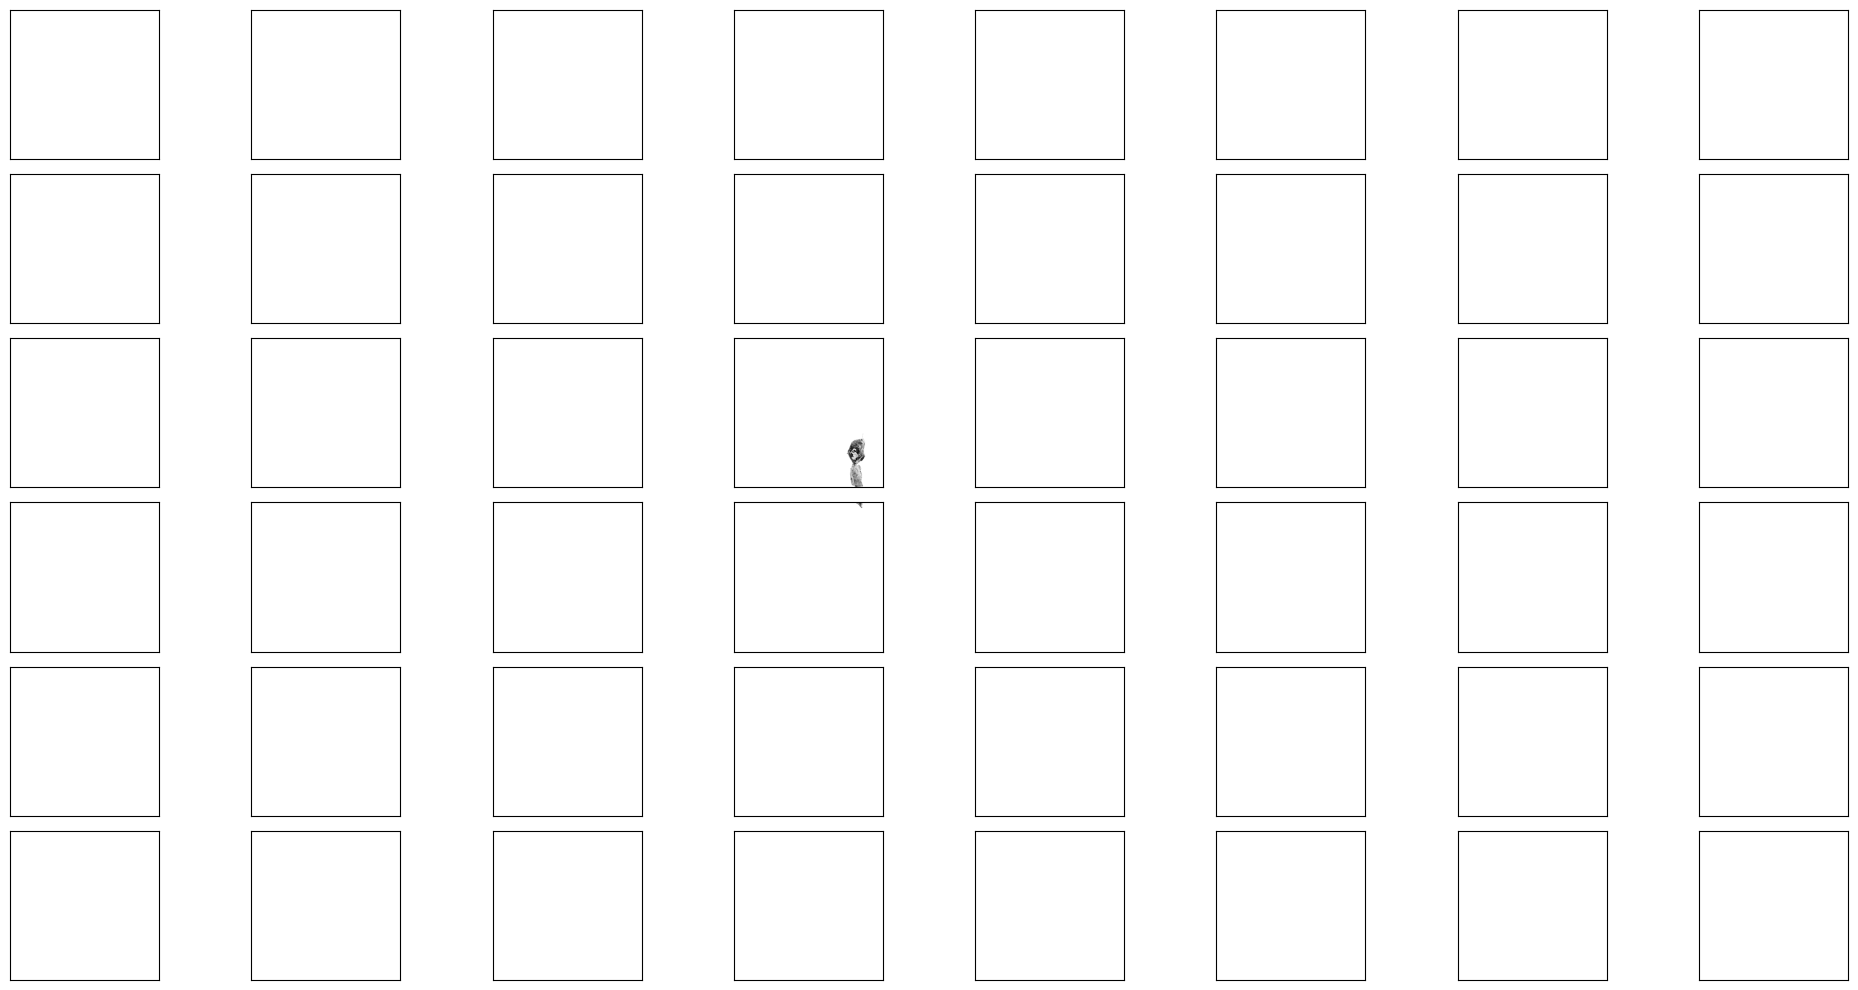

In [534]:
plt.figure(figsize=(20,10))
for i in range(48):
    plt.subplot(6, 8, i+1)
    plt.imshow(x[0,i].cpu().numpy().squeeze(), cmap='binary')
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [535]:
def filter_zero_patches(tensor):
    nonzero_mask = torch.sum(tensor, dim=(-3,-2,-1)) != 0
    filtered_tensor = tensor[nonzero_mask]
    return filtered_tensor, nonzero_mask

In [536]:
xf, mask = filter_zero_patches(x)
print('filtered tensor: {}'.format(xf.shape))
print('tensor mask:     {}'.format(mask.shape))

filtered tensor: torch.Size([31, 1, 504, 504])
tensor mask:     torch.Size([10, 48])


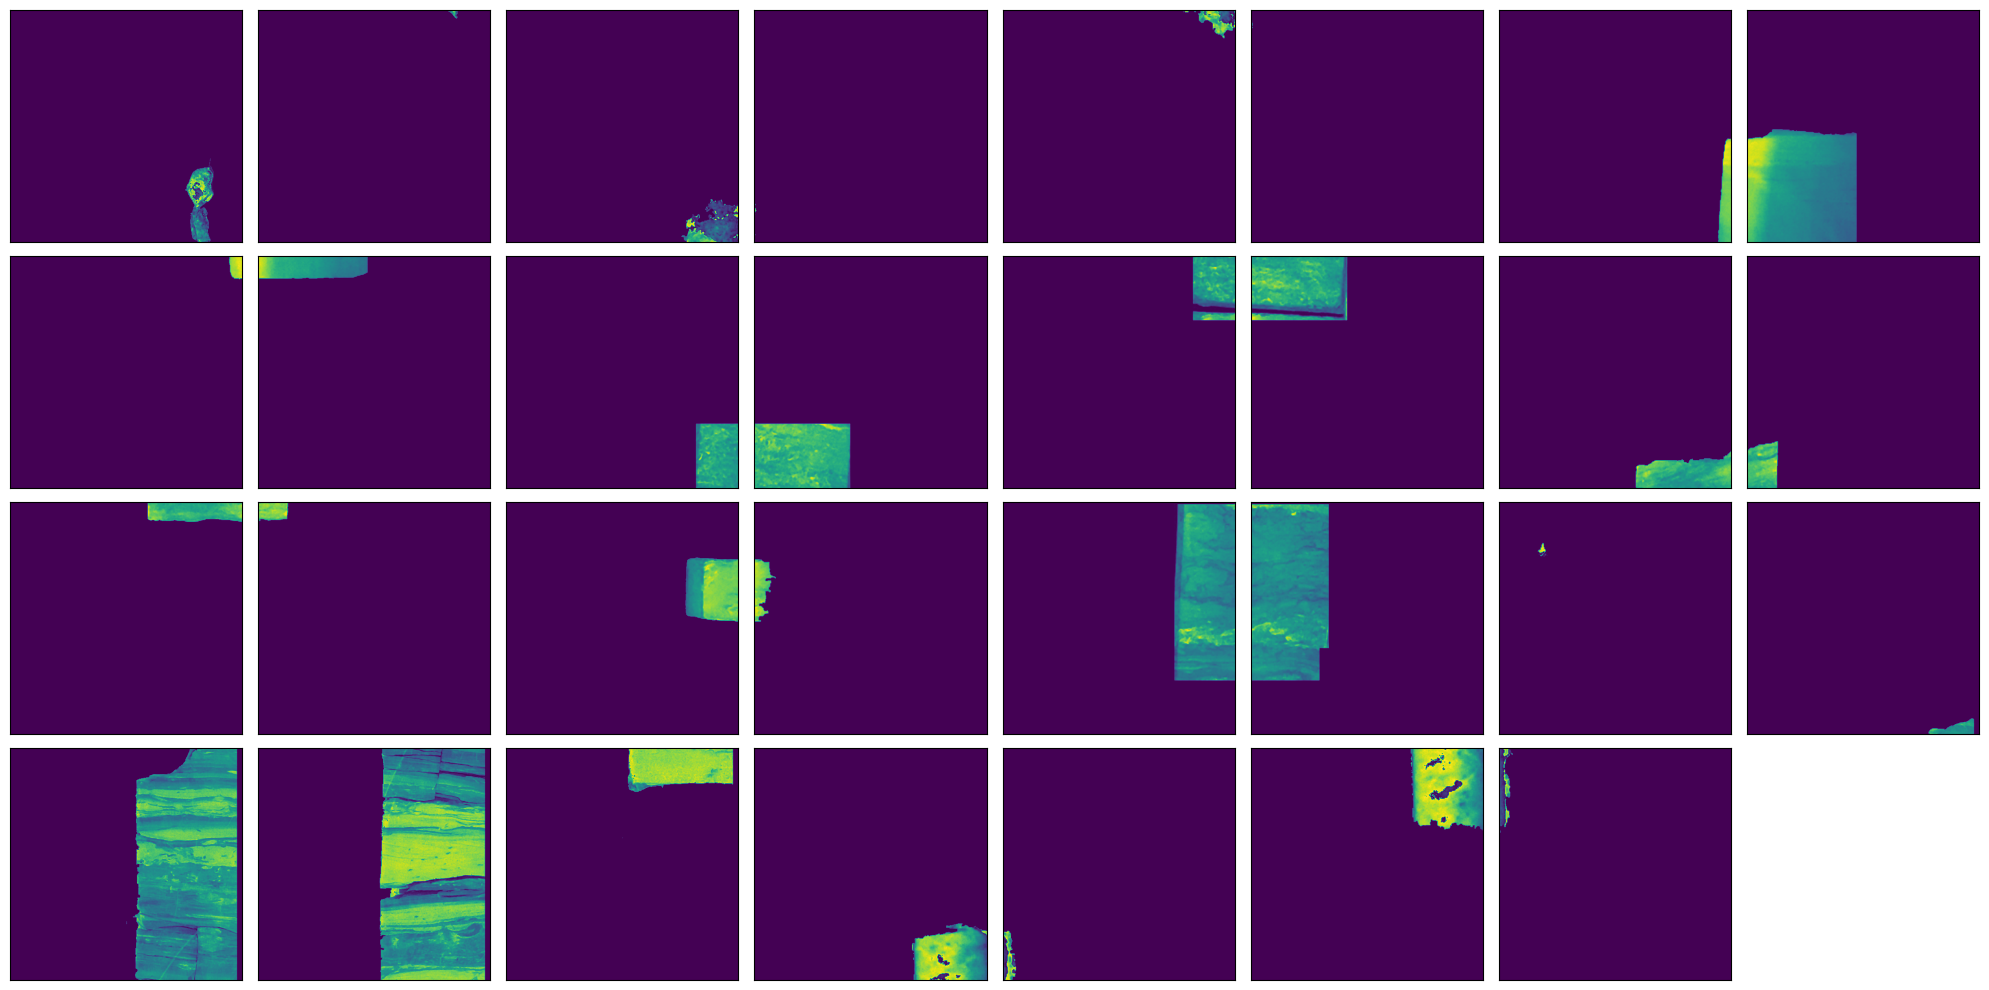

In [537]:
plt.figure(figsize=(20,10))
for i in range(31):
    plt.subplot(4, 8, i+1)
    plt.imshow(xf[i,0].cpu().numpy().squeeze())
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [450]:
model     = RockClassification().to(device)
nparams   = sum(p.numel() for p in model.parameters())
print('# parameters: {:,}'.format(nparams))

criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# parameters: 48,947


In [ ]:
epochs, monitor = 2, 10
train_loss, valid_loss = [], []

for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    epoch_valid_loss = []
    model.eval()
    with torch.no_grad():
        for j, (x_valid, y_valid) in enumerate(valid_loader):
            y_valid_pred = model(x_valid)
            vloss = criterion(y_valid_pred, y_valid)
            epoch_valid_loss.append(vloss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # monitor
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))
    
losses = pd.DataFrame({'train': train_loss, 'valid': valid_loss})
losses.to_csv('losses.csv')
torch.save(model.state_dict(), 'model.pth')

***
# END